In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
import sys, io
import pandas as pd 
from ipynb.fs.full.Data_Processing import *
from ipynb.fs.full.evaluation import *
from braindecode.datasets.xy import create_from_X_y
from braindecode.training.losses import CroppedLoss
import time
import numpy as np
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet , Deep4Net 
from skorch.callbacks import LRScheduler, EarlyStopping
from skorch.helper import predefined_split
from braindecode import EEGClassifier , EEGRegressor
from collections import namedtuple
import pickle
from sklearn.model_selection import KFold

In [14]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

In [15]:
def standardise(X_train, X_valid):
    # standardize per channel
    means = X_train.mean(axis=(0,2), keepdims=True)
    stds = X_train.std(axis=(0,2), keepdims=True)
    X_train = (X_train - means) / (stds)
    X_valid = (X_valid - means) / (stds)
    return X_train, X_valid


In [16]:
def choose_cnn (model_depth, model_type, trainset, validset , n_classes , device, cuda , n_epochs):
    # Extract number of chans and time steps from dataset
    n_chans = trainset[0][0].shape[0]
    input_window_samples = trainset[0][0].shape[1]

    if model_depth == 'shallow':
        lr = 0.0625 * 0.01
        weight_decay = 0
        model =  ShallowFBCSPNet(n_chans, n_classes, input_window_samples=input_window_samples, final_conv_length="auto")
    else:
        lr = 1 * 0.01
        weight_decay = 0.5 * 0.001
        """
        For 30 samples, filter time_length = 1
        For 60 > samples, filter time length is left empty
        for 15 samples, filter_time length = 1, filter_length_2 = 1, filter_length_3 = 1
        """
        model =  Deep4Net(n_chans, n_classes, input_window_samples=input_window_samples,
                  final_conv_length='auto', pool_time_length=1, filter_time_length = 1,pool_time_stride=1)
    if cuda:
        model = model.cuda(0)

    batch_size = 32
    
    if model_type == 'clf':
        clf = EEGClassifier(
        model,
        criterion=torch.nn.NLLLoss,
        optimizer=torch.optim.AdamW,
        train_split=predefined_split(validset),  # using valid_set for validation
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        callbacks=[
            "accuracy", 
            ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)), 
           ("EarlyStopping", EarlyStopping(monitor = 'valid_loss', threshold = 0.00001)),
        ],
        device=device,)
        return clf
    else:
        
        # remove softmax
        new_model = torch.nn.Sequential()
        for name, module_ in model.named_children():
            if "softmax" in name:
                continue
            new_model.add_module(name, module_)
            
        model = new_model

        regressor = EEGRegressor(
        model,
        cropped = False,
        criterion=CroppedLoss,
        criterion__loss_function=torch.nn.functional.mse_loss,
        optimizer=torch.optim.AdamW,
        train_split=predefined_split(validset),
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        iterator_train__shuffle=True,
        batch_size=batch_size,
        callbacks=[
            "neg_root_mean_squared_error",
            # seems n_epochs -1 leads to desired behavior of lr=0 after end of training?
            ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)), 
           ("EarlyStopping", EarlyStopping(monitor = 'valid_loss', threshold = 0.00001)),
        ],
        device=device)
        return regressor
        

In [17]:
def average(lst): 
    return sum(lst) / len(lst)

In [18]:
def categorise(y_train, y_valid):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_valid = le.transform(y_valid)
    return y_train, y_valid, le

In [19]:
def is_slice_in_list(s,l):
    """
    Function for checking whether a slice is in a list. Mainly used for checking whether the 
    """
    len_s = len(s) #so we don't recompute length of s on every iteration
    return any(s == l[i:len_s+i] for i in range(len(l) - len_s+1))

In [20]:
def kfold_predict (X,y, model_type, n_epochs, model_depth):
    kf= KFold(n_splits = 5, shuffle = True, random_state =  1)

    if model_type == 'clf':
        results = {"Accuracy":[], "Precision":[], "Recall":[], "F1 Score Macro":[],
              "F1 Score Micro":[],"Balanced Accuracy":[]}
    else:
        results = {'RMSE':[], 'R2':[]}

    total_predictions = []
    total_true = []
    num_classes = 0
    clf = None
    for train_index, test_index in kf.split(X):
        print("Train: ", train_index, "Validation: ", test_index)

        #Train/test split
        X_train, X_valid = np.concatenate(X[train_index]), np.concatenate(X[test_index])
        y_train, y_valid = np.concatenate(y[train_index]).astype('int'), np.concatenate(y[test_index]).astype('int')
        
        # check the the classes in the validation set
        y_valid_classes = list(set(y_valid))
        y_train_classes = list(set(y_train))
        if is_slice_in_list(y_valid_classes, y_train_classes) == False: continue
        print(set(y_train))
        print(set(y_valid))

        size = len(X_train) + len(X_valid) #get dataset size

        #standardise per channel
        X_train, X_valid = standardise(X_train, X_valid)
        
        #label the categorical variables
        if model_type == 'clf':
            y_train, y_valid, le = categorise(y_train, y_valid)
            
        # Convert training and validation sets into a suitable format
        save_stdout = sys.stdout
        sys.stdout = open('/cs/tmp/ybk1/trash', 'w')
        trainset = create_from_X_y(X_train, y_train, drop_last_window=False)
        validset = create_from_X_y(X_valid, y_valid, drop_last_window=False)
        sys.stdout = save_stdout

        # count the number of classes
        if len(set(y_train)) > num_classes:
            num_classes = len(set(y_train))

        # commence the training process
        time_start = time.time()
        save_stdout = sys.stdout
        sys.stdout = open('/cs/tmp/ybk1/trash', 'w')
        cnn = choose_cnn (model_depth, model_type, trainset, validset , num_classes , device, cuda, n_epochs).fit(trainset, y=None, epochs=n_epochs)
        
        sys.stdout = save_stdout
        print('Training completed created! Time elapsed: {} seconds'.format(time.time()-time_start))

        # make predictions
        if model_type == 'clf':
            y_pred = le.inverse_transform(cnn.predict(X_valid))
            y_true = le.inverse_transform(y_valid)
        else:
            y_pred = cnn.predict(X_valid)
            y_true = y_valid
            
        total_predictions.append(y_pred)
        total_true.append(y_true) 
        r = get_results(y_true, y_pred, model_type)

        for key in r: # loop through dictionary to add to all the scores to the results dictionary
            results[key].append(r[key])
        

    for key in results: # finallly average out the results 
        results[key] = average(results[key])
   
    return results, np.concatenate(total_predictions), np.concatenate(total_true), num_classes, size, cnn

In [21]:
def save_plots(y_true, y_pred, user, label, model_depth, bandpass, window_size_samples, model_type, cnn):
    if model_type == 'clf':
        # plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        saved_file = "results/CNN/{5}/confusion/k fold/{2}/per user/User_{0}_Label_{1}_bandpass_{3}_window_{4}.png".format(user, label, model_depth, bandpass, window_size_samples, model_type)
        plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)

    #plot loss curve
    plot_loss_curve(cnn)
    plt.savefig("results/CNN/{5}/loss curves/k fold/{2}/per user/User_{0}_Label_{1}_bandpass_{3}_window_{4}.png".format(user, label, model_depth, bandpass, window_size_samples, model_type))

    if model_type == 'reg':
        saved_file = "results/CNN/{5}/y vs y_pred/{2}/per user/User_{0}_Label_{1}_bandpass_{3}_window_{4}.png".format(user, label, model_depth, bandpass, window_size_samples, model_type)
        plot_model(y_true, y_pred, user, label,file=saved_file)   

In [22]:
def run_per_user_sd(model_type, bandpass):
    """
    Method for running the CNN per user
    """
    model_depths = ['shallow', 'deep']
    results = []
    for model_depth in model_depths:
        
        print ("Starting the {0} CNN Model...".format(model_depth))
        time_original = time.time()

        
        labels = ['attention','interest','effort']
        window_size_samples = 120
        n_epochs = 100
    #     saved_file = "/cs/home/ybk1/Dissertation/data/all_users_sampled_with_individual_tests_30_window_annotated_EEG.pickle"
        saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_no_agg_bandpass_{1}_slider_{0}.pickle".format(window_size_samples, bandpass)
        all_tests = load_file(saved_file)
        users = all_tests.keys()

        for user in users:
            print("Working on user {0}".format(user))
            torch.backends.cudnn.benchmark = True

            for label in labels:
                time_start = time.time()
                dt = all_tests[user] # dictionary of all the individual tests per user

                X = np.array([np.array(x).transpose(0,2,1).astype(np.float32) for x in dt['inputs']])     
                y = np.array([np.array(x) for x in dt[label]]) #Convert the categories into labels

                # train and make predictions
                r, y_pred, y_true, num_classes, size, cnn = kfold_predict(X,y, model_type, n_epochs, model_depth)
                print(r['Accuracy'])

                 # get results
                duration = time.time() - time_start
                results.append(collate_results(r, user, label, duration, num_classes, size, model_type, n_epochs, window_size_samples, model_depth))

                save_plots(y_true, y_pred, user, label, model_depth, bandpass, window_size_samples, model_type, cnn)

                print("Finished analysis on User {0}_{1}".format(user,label))
            print("Finished analysis on User {0}".format(user))
        results  = pd.DataFrame(results)
        results.to_csv("results/CNN/{3}/tabulated/k fold/{2}/{2}performance_window_size_{0}_{1}_per_user_bandpass_{4}.csv".format(window_size_samples, n_epochs, model_depth , model_type, bandpass), index=False )
        final_duration = time.time()- time_original
        print("All analyses are complete! Time elapsed: {0}".format(final_duration))
        return results

In [23]:
def run_cross_user_sd(model_type, bandpass):
    
    model_depths = ['shallow', 'deep']
    for model_depth in model_depths:

        print ("Starting the {0} CNN Model...".format(model_depth))

        time_original = time.time()

        window_size_samples = 120

        n_epochs = 100
        results = []
        labels = ['attention','interest','effort']

        saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_agg_bandpass_{1}_slider_{0}.pickle".format(window_size_samples, bandpass)
        all_tests_agg = load_file(saved_file)
        users = all_tests_agg.keys()
        user ='all'
        torch.backends.cudnn.benchmark = True

        for label in labels:
            print("Working on label {0}".format(label))
            time_start = time.time()


            # convert the inputs  into #samples, channels, #timepoints format
            X = np.array([all_tests_agg[user]['inputs'].transpose(0,2,1).astype(np.float32) for user in all_tests_agg])
            y = np.array([all_tests_agg[user][label] for user in all_tests_agg])  

            # train and make predictions
            r, y_pred, y_true, num_classes, size, cnn = kfold_predict(X,y, model_type, n_epochs, model_depth)

             # get results
            duration = time.time() - time_start
            results.append(collate_results(r, user, label, duration, num_classes, size, model_type, n_epochs, window_size_samples, model_depth))

            #save plots
            save_plots(y_true, y_pred, user, label, model_depth, bandpass, window_size_samples, model_type, cnn)


            print("Finished analysis on label {0}".format(label))
        print("Finished analysis on User {0}".format(user))
        results  = pd.DataFrame(results)
        results.to_csv("results/CNN/{3}/tabulated/k fold/{1}/{1}CNN_Valid_performance_window_size_{0}_cross_user_bandpass_{2}.csv".format(window_size_samples , model_depth,bandpass, model_type), index=False )
        final_duration = time.time()- time_original
        print("All analyses are complete! Time elapsed: {0}".format(final_duration))

    return results

Starting the shallow CNN Model...
Working on label attention
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 95.04976654052734 seconds
Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 170.90883898735046 seconds
Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 121.47887706756592 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 92.82455325126648 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 75.56693887710571 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalized confusion matrix
Finished analysis on label attention
Working on label interest
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 106.76610398292542 seconds
Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 122.2304253578186 seconds
Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 146.38795375823975 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 199.3344419002533 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 100.88968181610107 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalized confusion matrix
Finished analysis on label interest
Working on label effort
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 118.53725957870483 seconds
Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 145.90101385116577 seconds
Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 121.33935284614563 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 213.0158953666687 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 126.09628534317017 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalized confusion matrix
Finished analysis on label effort
Finished analysis on User all
All analyses are complete! Time elapsed: 3319.7265923023224
Starting the deep CNN Model...
Working on label attention
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 86.4786148071289 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 132.73220133781433 seconds
Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 88.26750135421753 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 129.5188810825348 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 183.23779797554016 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalized confusion matrix
Finished analysis on label attention
Working on label interest
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 85.5858302116394 seconds
Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 132.00278043746948 seconds
Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 102.40694260597229 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 113.18420219421387 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 106.79323506355286 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalized confusion matrix
Finished analysis on label interest
Working on label effort
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 114.97429656982422 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 117.6841995716095 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 131.57670664787292 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 144.5308039188385 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 91.76606750488281 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalized confusion matrix
Finished analysis on label effort
Finished analysis on User all
All analyses are complete! Time elapsed: 3128.2799837589264


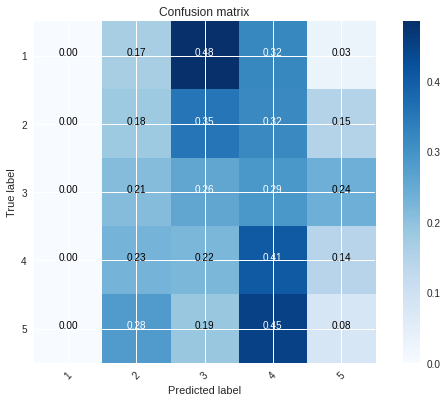

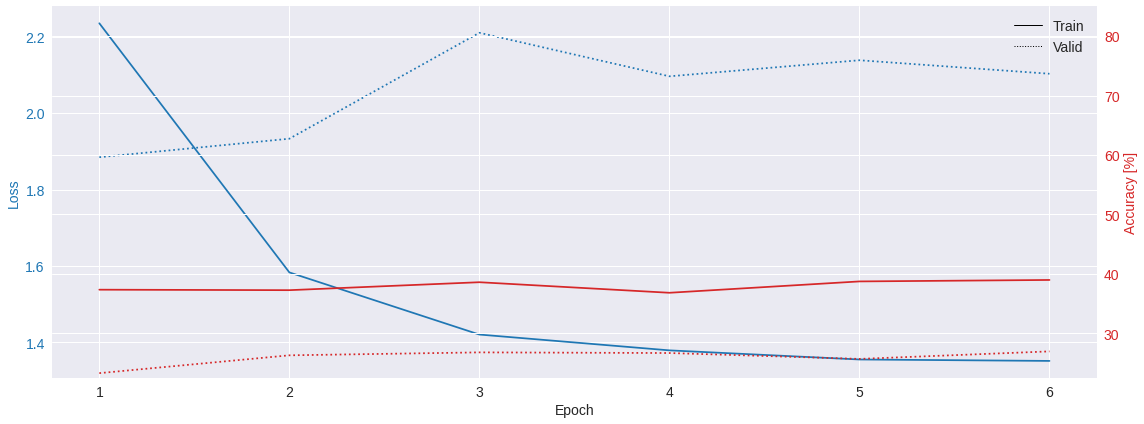

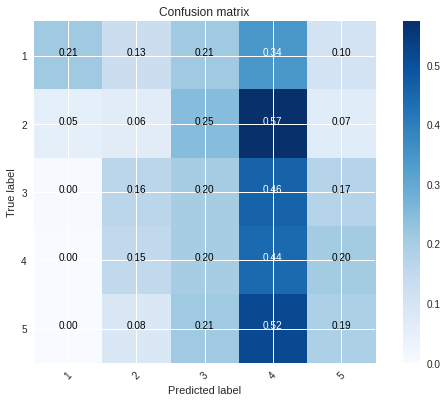

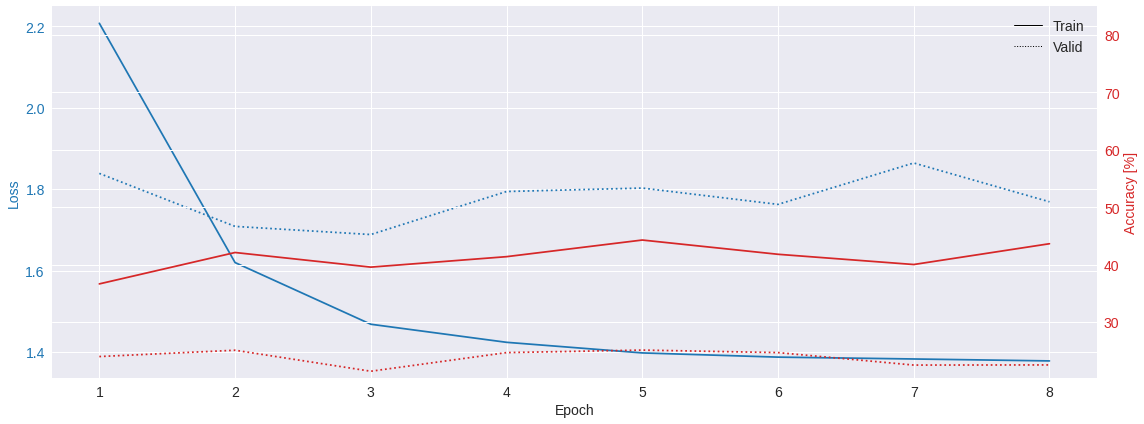

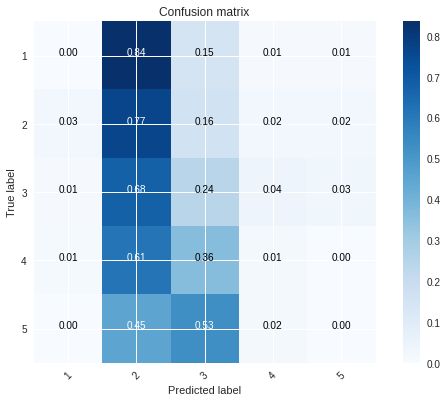

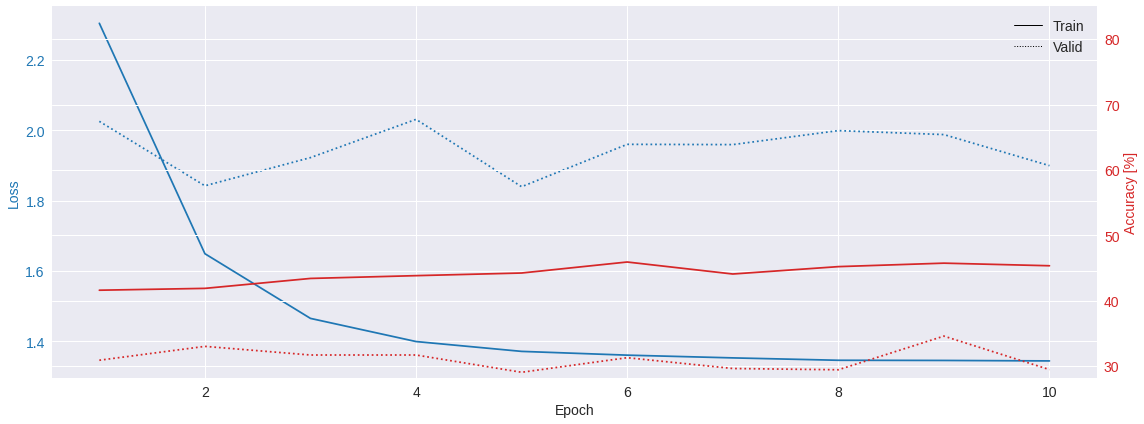

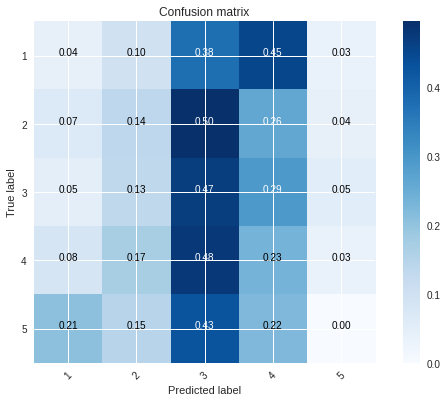

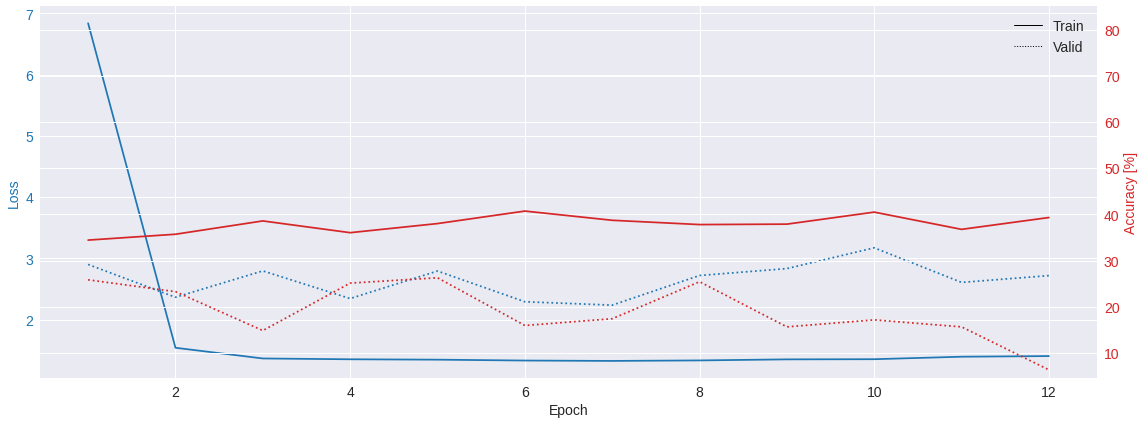

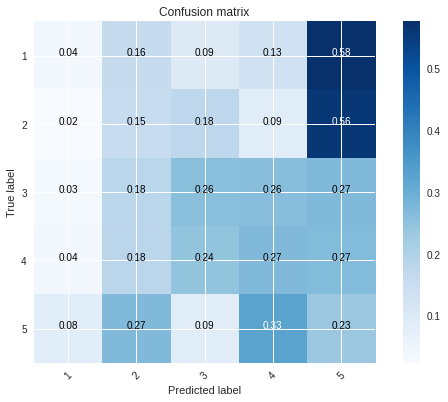

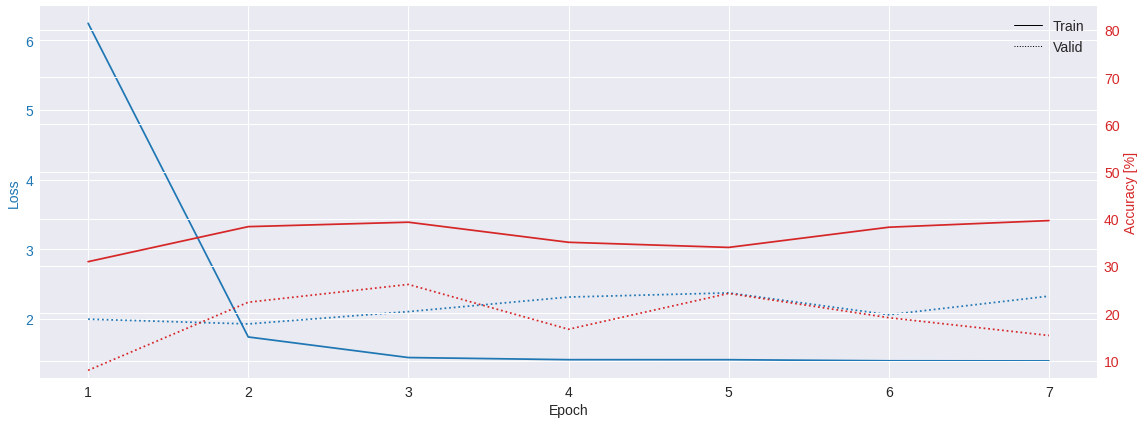

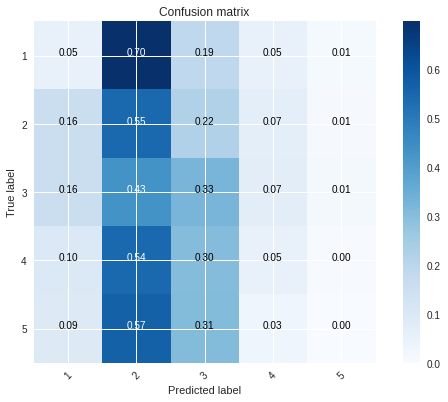

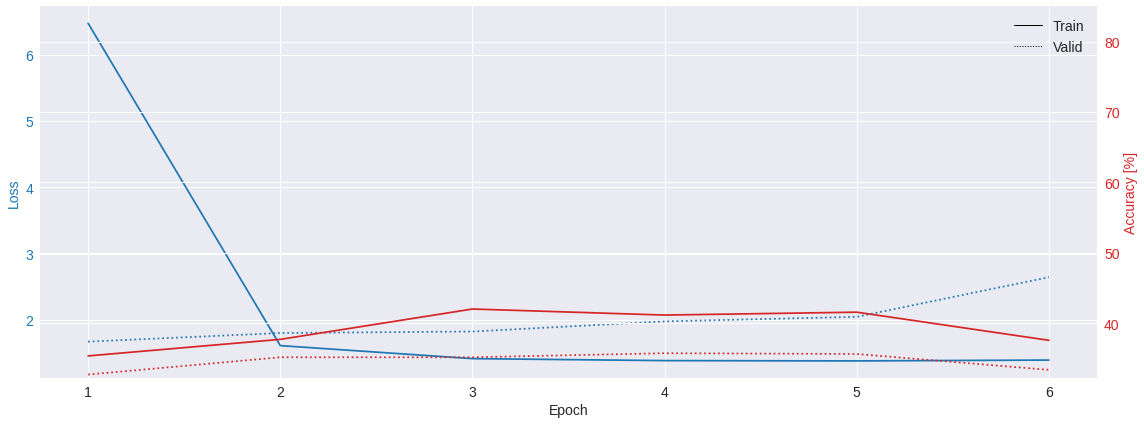

In [24]:

def run_shallow_deep(model_type, bandpass, eval_type='cross user'):
    if eval_type == 'per user':
        run_per_user_sd(model_type, bandpass)
    elif eval_type == 'cross user':
        run_cross_user_sd(model_type, bandpass)
    elif eval_type == 'both':
        
        results = []
        
        cross_results = run_cross_user_sd(model_type, bandpass)
        per_results = run_per_user_sd(model_type, bandpass)
        
        results.append(run_cross_user_sd(model_type, bandpass))
        results.append(run_per_user_sd(model_type, bandpass))
        
        results = pd.concat(results)
        file = "results/CNN/{0}/tabulated/k fold/shallowDeep/shallowDeep_evaltype_{1}_bandpass_{2}".format(model_type, eval_type, bandpass)
        results.to_csv(file,index=False)
        return results

        

results = run_shallow_deep('clf',True)

